In [1]:
import pandas as pd
import numpy as np
import pickle as p

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
#tf.enable_eager_execution()
from sklearn.model_selection import train_test_split

from PIL import Image

Compile the training data

In [2]:
meta_data = pd.read_csv('/home/ec2-user/training_data_meta.csv')

#Join cleaned class data with training metadata

class_data = pd.read_csv('/home/ec2-user/stanford_labels_cleaned.csv')

meta_data = pd.merge(meta_data, class_data, on = 'class', how = 'left')

meta_data = meta_data.loc[meta_data['Body Type'].isin(['Coupe', 'Sedan'])].copy()

meta_data['is_sedan_target'] = (meta_data['Body Type'] == 'Sedan').astype(int)

image_dict = p.load(open('/home/ec2-user/scaled_bounded_grayscale_dict.p', 'rb'))

training_data = []
for i in meta_data[['is_sedan_target', 'fname']].iterrows():
    row = [i[1]['is_sedan_target']]
    row.extend(image_dict[i[1]['fname']].flatten())
    training_data.append(row)

training_data = np.array(training_data).astype(float)

Prep the data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(training_data[:,1:], 
                                                    training_data[:,0], 
                                                    test_size=0.30, 
                                                    random_state=420)

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

negatives = []
for ind, elem in enumerate(y_train):
    if elem == 0:
        negatives.append(ind)
np.random.shuffle(negatives)

neg_dupe_target = 2 * y_train.sum() - y_train.shape[0]

X_train = np.concatenate([X_train, X_train[negatives[0:neg_dupe_target],:]],
                         axis = 0
                        )
y_train = np.concatenate([y_train, y_train[negatives[0:neg_dupe_target]]],
                         axis = 0
                        )

y_train = np.concatenate([1 - y_train.reshape(-1,1), y_train.reshape(-1,1)], axis = 1)
y_test = np.concatenate([1 - y_test.reshape(-1,1), y_test.reshape(-1,1)], axis = 1)

Define the model

In [4]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    
    #Define model architecture
    
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    input_layer = tf.reshape(features, [-1, 200, 200, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 3x3 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 25, 25, 1]
    # Output Tensor Shape: [batch_size, 25, 25, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 25, 25, 32]
    # Output Tensor Shape: [batch_size, 12, 12, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 3x3 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 12, 12, 32]
    # Output Tensor Shape: [batch_size, 12, 12, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 12, 12, 64]
    # Output Tensor Shape: [batch_size, 6, 6, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 12, 12, 64]
    # Output Tensor Shape: [batch_size, 6, 6, 64]
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool3_flat = tf.reshape(pool3, [-1, 25 * 25 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool3_flat, units=256, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=2)
    
    #Predict Op
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        #Define model outputs
        # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:,1], logits=logits)
        
        predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }
        # Name tensors to be logged with LoggingTensorHook.
        accuracy = tf.metrics.auc(
              labels=labels, predictions=predictions["probabilities"])
        #tf.identity(accuracy[1], name='train_accuracy')

        # Save accuracy scalar to Tensorboard output.
        tf.summary.scalar('train_accuracy', accuracy[1])
        
        logging_hook = tf.train.LoggingTensorHook(
            {"loss" : loss,
             'train_accuracy' : accuracy[1]
            },
            every_n_iter=10)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op, training_hooks = [logging_hook])
    # Add evaluation metrics (for EVAL mode)
    if mode == tf.estimator.ModeKeys.EVAL:
        #Define model outputs
        # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:,1], logits=logits)
        
        predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }
        #swap this for AUROC?
        eval_metric_ops = {
          "eval_accuracy": tf.metrics.auc(
              labels=labels, predictions=predictions["probabilities"])}

        return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
session_config = tf.ConfigProto(
      inter_op_parallelism_threads=16,
      intra_op_parallelism_threads=16,
      )

#distribution = tf.contrib.distribute.CollectiveAllReduceStrategy()

config = tf.estimator.RunConfig(session_config = session_config,
                                log_step_count_steps = 10,
                                save_summary_steps = 10
                                #train_distribute=distribution,
                               )

# Create the Estimator
car_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="/home/ec2-user/convnet_model", config = config)

INFO:tensorflow:Using config: {'_model_dir': '/home/ec2-user/convnet_model', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': intra_op_parallelism_threads: 16
inter_op_parallelism_threads: 16
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f385871d9b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
## Train the model
# train_input_fn = tf.estimator.inputs.numpy_input_fn(
#   x={"x": X_train},
#   y=y_train,
#   batch_size=32,
#   num_epochs=None,
#   shuffle=True)

# #custom input function using training_image_processor
# def image_processor_input_fn(image_processor, X_train, y_train, batch_size):
#     features, labels = next(image_processor.flow(X_train.reshape((X_train.shape[0], 200, 200, 1)), 
#                                                  y_train, batch_size))
#     return {'x' : features.astype(float)}, labels
        
#custom input function using training_image_processor with tf.data.Dataset
def image_processor_train_input_fn(image_processor, X_train, y_train, batch_size):
    
    dataset = tf.data.Dataset.from_generator(
        generator = lambda : image_processor.flow(X_train.reshape((X_train.shape[0], 200, 200, 1)), 
                                                  y_train, batch_size, shuffle = True), 
        output_types = (np.float32, np.int32))
    
    dataset = dataset.shuffle(512).repeat()
    
    return dataset

training_image_processor = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    #shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    data_format = 'channels_last'
)

In [7]:
testing_image_processor = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    data_format = 'channels_last'
)

def image_processor_eval_input_fn(image_processor, X_test, y_test, batch_size):
    
    dataset = tf.data.Dataset.from_tensor_slices((X_test.astype('float32'), 
                                                  y_test.astype('int32')))
        
    return dataset.batch(batch_size)

Train

In [ ]:
car_classifier.train(
      input_fn=lambda:image_processor_train_input_fn(training_image_processor, X_train, y_train, 16),
      steps=30000
    )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-30237
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30237 into /home/ec2-user/convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.35128447, step = 30238
INFO:tensorflow:loss = 0.35128447, train_accuracy = 0.9062499
INFO:tensorflow:global_step/sec: 2.04962
INFO:tensorflow:loss = 0.26676762, step = 30248 (4.880 sec)
INFO:tensorflow:loss = 0.26676762, train_accuracy = 0.9345703 (4.879 sec)
INFO:tensorflow:global_step/sec: 2.13538
INFO:tensorflow:loss = 0.16081412, step = 30258 (4.683 sec)
INFO:tensorflow:loss = 0.16081412, train_accuracy = 0.9552952 (4.683 sec)
INFO:tensorflow:global_step/sec: 2.14278
INFO:tensorflow:loss = 0.089477316, step = 30268 (4.667 sec)
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 2.41154
INFO:tensorflow:loss = 0.12826824, step = 30688 (4.147 sec)
INFO:tensorflow:loss = 0.12826824, train_accuracy = 0.9785635 (4.147 sec)
INFO:tensorflow:global_step/sec: 2.41619
INFO:tensorflow:loss = 0.12230997, step = 30698 (4.138 sec)
INFO:tensorflow:loss = 0.12230997, train_accuracy = 0.9789957 (4.138 sec)
INFO:tensorflow:global_step/sec: 2.44497
INFO:tensorflow:loss = 0.21513739, step = 30708 (4.090 sec)
INFO:tensorflow:loss = 0.21513739, train_accuracy = 0.97885144 (4.090 sec)
INFO:tensorflow:global_step/sec: 2.41355
INFO:tensorflow:loss = 0.18773556, step = 30718 (4.143 sec)
INFO:tensorflow:loss = 0.18773556, train_accuracy = 0.9790298 (4.143 sec)
INFO:tensorflow:global_step/sec: 2.41924
INFO:tensorflow:loss = 0.12711093, step = 30728 (4.133 sec)
INFO:tensorflow:loss = 0.12711093, train_accuracy = 0.97941333 (4.133 sec)
INFO:tensorflow:global_step/sec: 2.41776
INFO:tensorflow:loss = 0.27503017, step = 30738 (4.136 sec)
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 2.40445
INFO:tensorflow:loss = 0.22419833, step = 31158 (4.159 sec)
INFO:tensorflow:loss = 0.22419833, train_accuracy = 0.975439 (4.159 sec)
INFO:tensorflow:global_step/sec: 2.44285
INFO:tensorflow:loss = 0.36459845, step = 31168 (4.094 sec)
INFO:tensorflow:loss = 0.36459845, train_accuracy = 0.97493356 (4.094 sec)
INFO:tensorflow:global_step/sec: 2.40611
INFO:tensorflow:loss = 0.035090275, step = 31178 (4.156 sec)
INFO:tensorflow:loss = 0.035090275, train_accuracy = 0.97539836 (4.156 sec)
INFO:tensorflow:global_step/sec: 2.41932
INFO:tensorflow:loss = 0.19115107, step = 31188 (4.133 sec)
INFO:tensorflow:loss = 0.19115107, train_accuracy = 0.9754187 (4.134 sec)
INFO:tensorflow:global_step/sec: 2.39371
INFO:tensorflow:loss = 0.1104641, step = 31198 (4.178 sec)
INFO:tensorflow:loss = 0.1104641, train_accuracy = 0.9757271 (4.177 sec)
INFO:tensorflow:global_step/sec: 2.40821
INFO:tensorflow:loss = 0.22599998, step = 31208 (4.152 sec)
INFO:tensorflow:loss = 

INFO:tensorflow:global_step/sec: 2.46972
INFO:tensorflow:loss = 0.1537116, step = 31628 (4.049 sec)
INFO:tensorflow:loss = 0.1537116, train_accuracy = 0.9719057 (4.049 sec)
INFO:tensorflow:Saving checkpoints for 31629 into /home/ec2-user/convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 2.33068
INFO:tensorflow:loss = 0.3213901, step = 31638 (4.291 sec)
INFO:tensorflow:loss = 0.3213901, train_accuracy = 0.9716981 (4.291 sec)
INFO:tensorflow:global_step/sec: 2.387
INFO:tensorflow:loss = 0.0872975, step = 31648 (4.189 sec)
INFO:tensorflow:loss = 0.0872975, train_accuracy = 0.9719641 (4.189 sec)
INFO:tensorflow:global_step/sec: 2.38135
INFO:tensorflow:loss = 0.1992482, step = 31658 (4.199 sec)
INFO:tensorflow:loss = 0.1992482, train_accuracy = 0.9720047 (4.199 sec)
INFO:tensorflow:global_step/sec: 2.42054
INFO:tensorflow:loss = 0.20902126, step = 31668 (4.131 sec)
INFO:tensorflow:loss = 0.20902126, train_accuracy = 0.9719995 (4.131 sec)
INFO:tensorflow:global_step/sec: 2.41047
INF

INFO:tensorflow:loss = 0.24143866, train_accuracy = 0.9722829 (4.165 sec)
INFO:tensorflow:global_step/sec: 2.39643
INFO:tensorflow:loss = 0.24814251, step = 32098 (4.173 sec)
INFO:tensorflow:loss = 0.24814251, train_accuracy = 0.972212 (4.173 sec)
INFO:tensorflow:global_step/sec: 2.38196
INFO:tensorflow:loss = 0.33239985, step = 32108 (4.198 sec)
INFO:tensorflow:loss = 0.33239985, train_accuracy = 0.97202766 (4.198 sec)
INFO:tensorflow:global_step/sec: 2.36642
INFO:tensorflow:loss = 0.05371331, step = 32118 (4.226 sec)
INFO:tensorflow:loss = 0.05371331, train_accuracy = 0.9722715 (4.226 sec)
INFO:tensorflow:global_step/sec: 2.40897
INFO:tensorflow:loss = 0.20444694, step = 32128 (4.151 sec)
INFO:tensorflow:loss = 0.20444694, train_accuracy = 0.972288 (4.151 sec)
INFO:tensorflow:global_step/sec: 2.41296
INFO:tensorflow:loss = 0.27873856, step = 32138 (4.144 sec)
INFO:tensorflow:loss = 0.27873856, train_accuracy = 0.97218376 (4.144 sec)
INFO:tensorflow:global_step/sec: 2.39863
INFO:tenso

INFO:tensorflow:loss = 0.15122347, train_accuracy = 0.97230095 (4.176 sec)
INFO:tensorflow:global_step/sec: 2.42789
INFO:tensorflow:loss = 0.1819836, step = 32568 (4.119 sec)
INFO:tensorflow:loss = 0.1819836, train_accuracy = 0.9723401 (4.119 sec)
INFO:tensorflow:global_step/sec: 2.40181
INFO:tensorflow:loss = 0.05756717, step = 32578 (4.163 sec)
INFO:tensorflow:loss = 0.05756717, train_accuracy = 0.97252434 (4.163 sec)
INFO:tensorflow:global_step/sec: 2.41339
INFO:tensorflow:loss = 0.076050684, step = 32588 (4.144 sec)
INFO:tensorflow:loss = 0.076050684, train_accuracy = 0.9726804 (4.144 sec)
INFO:tensorflow:global_step/sec: 2.42241
INFO:tensorflow:loss = 0.38187128, step = 32598 (4.128 sec)
INFO:tensorflow:loss = 0.38187128, train_accuracy = 0.9724679 (4.128 sec)
INFO:tensorflow:global_step/sec: 2.38402
INFO:tensorflow:loss = 0.24240394, step = 32608 (4.195 sec)
INFO:tensorflow:loss = 0.24240394, train_accuracy = 0.9724238 (4.195 sec)
INFO:tensorflow:global_step/sec: 2.39304
INFO:ten

Evaluate Performance

In [55]:
print('training error')
eval_results = car_classifier.evaluate(
    input_fn=lambda:image_processor_eval_input_fn(testing_image_processor, X_train, y_train, 32))
print(eval_results)

print('testing error')
eval_results = car_classifier.evaluate(
    input_fn=lambda:image_processor_eval_input_fn(testing_image_processor, X_test, y_test, 32))
print(eval_results)

training error
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-14T03:29:49Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-30237
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-14-03:30:21
INFO:tensorflow:Saving dict for global step 30237: eval_accuracy = 0.7425077, global_step = 30237, loss = 128.50456
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30237: /home/ec2-user/convnet_model/model.ckpt-30237
{'eval_accuracy': 0.7425077, 'loss': 128.50456, 'global_step': 30237}
testing error
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-14T03:30:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-30237
INFO:tens

Run inference

In [52]:
predicted_classes = car_classifier.predict(
    input_fn=lambda:image_processor_eval_input_fn(testing_image_processor, X_test, y_test, 32))

testing_analysis = []

for pred, label in zip(predicted_classes, y_test):
    hold = [pred['probabilities'][1], pred['classes'], label[1]]
    testing_analysis.append(hold)
    
testing_analysis = pd.DataFrame(testing_analysis, columns = ['prob', 'class', 'label'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-26000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [53]:
testing_analysis.groupby('label')['class'].value_counts()

label  class
0      1        289
       0        167
1      1        598
       0         31
Name: class, dtype: int64

In [49]:
testing_analysis.groupby('label')['class'].value_counts()

label  class
0      1        264
       0        192
1      1        583
       0         46
Name: class, dtype: int64

In [19]:
testing_analysis.loc[(testing_analysis['class'] == 1) &
                     (testing_analysis['label'] == 1)].sort_values('label')

,prob,class,label
2,1.0,1,1
709,1.0,1,1
711,1.0,1,1
712,1.0,1,1
714,1.0,1,1
715,1.0,1,1
716,1.0,1,1
706,1.0,1,1
717,1.0,1,1
719,1.0,1,1


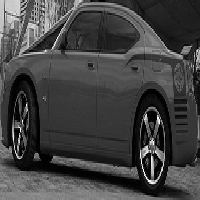

In [18]:
Image.fromarray((X_test[572,:].reshape((200,200))).astype('uint8'), mode = 'L')

In [12]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": X_train}, y=y_train, num_epochs=1, shuffle=False)
eval_results = car_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-02T02:05:09Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-1010
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-02-02:05:40
INFO:tensorflow:Saving dict for global step 1010: accuracy = 0.9997257, global_step = 1010, loss = 0.04455051
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1010: /home/ec2-user/convnet_model/model.ckpt-1010
{'accuracy': 0.9997257, 'loss': 0.04455051, 'global_step': 1010}


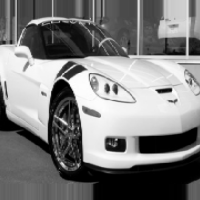

In [88]:
Image.fromarray((x_batch[0,:,:,0] * 255).astype('uint8'), mode = 'L')